In [1]:
import pennylane as qml

import numpy as np

from matplotlib import pyplot as plt

# np.set_printoptions(legacy="1.21")  # Fix annoying printing of numpy types

ModuleNotFoundError: No module named 'pennylane'

In [2]:
dev = qml.device("default.qubit", wires=2)

In [4]:
# Pauli matrices
Id = np.eye(2)
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

parameters = np.loadtxt("HamiltonianParameters.txt")

R = 90
H_param = parameters[parameters[:,0]==R,1:].flatten()

C = H_param[0]
Jx = H_param[1]
Jz = H_param[2]
#Jx = H_param[3]
Jxx = H_param[4]
Jxz = H_param[5]
#Jz = H_param[6]
#Jzx = H_param[7]
Jzz = H_param[8]

print(f"Jx={Jx}, Jz={Jz}, Jxx={Jxx}, Jzz={Jzz}, Jxz={Jxz}, C={C}")

def Hamiltonian():
    H = Jx * (np.kron(X,Id) + np.kron(Id,X))
    H = H + Jz * (np.kron(Z,Id) + np.kron(Id,Z))
    H = H + Jxx * np.kron(X,X)
    H = H + Jzz * np.kron(Z,Z)
    H = H + Jxz * (np.kron(X,Z) + np.kron(Z,X))
    H = H + C * np.kron(Id,Id)

    return H/2

def exactEnergy():
    H = Hamiltonian()

    E, V = np.linalg.eigh(H)
    return np.min(E)

print(f"Exact ground state energy is E = {exactEnergy()}")

Jx=-0.2288, Jz=-1.0466, Jxx=0.2613, Jzz=0.2356, Jxz=0.2288, C=-3.8505
Exact ground state energy is E = -2.8626207640766816


In [5]:
def H_operator():
    H = Jx/2 * (qml.PauliX(0) + qml.PauliX(1))
    H = H + Jz/2 * (qml.PauliZ(0) + qml.PauliZ(1))
    H = H + Jxx/2 * qml.PauliX(0) @ qml.PauliX(1)
    H = H + Jzz/2 * qml.PauliZ(0) @ qml.PauliZ(1)
    H = H + Jxz/2 * (qml.PauliX(0) @ qml.PauliZ(1) + qml.PauliZ(0) @ qml.PauliX(1))
    H = H + C/2 * qml.Identity(0)

    return H

H_qml = qml.matrix(H_operator())

E, _ = np.linalg.eigh(H_qml)
print(f"Exact ground state energy is E = {np.min(E)}")


Exact ground state energy is E = -2.8626207640766816


In [6]:
@qml.qnode(dev)
def ansatz(angles):
    theta = angles[:8]

    # inital rotations
    qml.RX(theta[0], wires=0)
    qml.RZ(theta[1], wires=0)
    qml.RX(theta[2], wires=1)
    qml.RZ(theta[3], wires=1)

    # CNOT to entangle
    qml.CZ(wires=[0,1])

    # second round of rotations
    qml.RX(theta[4], wires=0)
    qml.RZ(theta[5], wires=0)
    qml.RX(theta[6], wires=1)
    qml.RZ(theta[7], wires=1)

    # return all of the expectation values that are needed to compute the energy
    return qml.expval(qml.PauliX(0)), qml.expval(qml.PauliX(1)), qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliX(0) @ qml.PauliX(1)), qml.expval(qml.PauliZ(0) @ qml.PauliZ(1)), qml.expval(qml.PauliX(0) @ qml.PauliZ(1)), qml.expval(qml.PauliZ(0) @ qml.PauliX(1))

In [7]:
def energy_from_circuit(terms):
    # compute the energy from the expectation values
    E = 0
    E = E + Jx/2 * (terms[0] + terms[1])
    E = E + Jz/2 * (terms[2] + terms[3])
    E = E + Jxx/2 * terms[4]
    E = E + Jzz/2 * terms[5]
    E = E + Jxz/2 * (terms[6] + terms[7])
    E = E + C/2
    return E

(0.10676274578121048, -0.3226949350390396, -0.8090169943749475, -0.49651699437494734, -0.12131143785156606, 0.6545084971874735, 0.3595805565233817, 0.2795084971874739)
-1.082997871878185


(<Figure size 800x300 with 1 Axes>, <Axes: >)

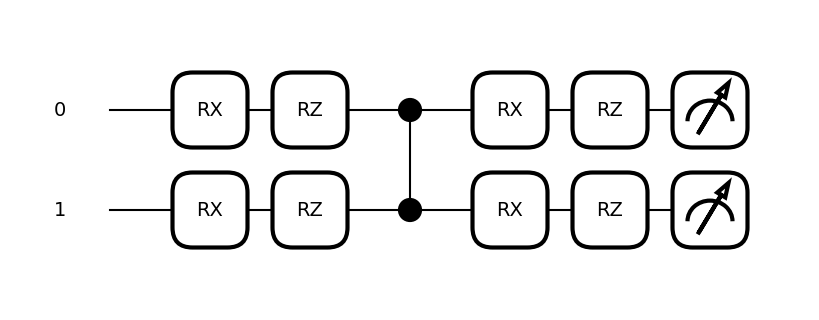

In [8]:
theta = list(2*np.pi*np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]))
angles = theta

qml.set_shots(8192)
test_circuit = ansatz(angles)
print(test_circuit)
print(energy_from_circuit(test_circuit))

qml.drawer.use_style("black_white")
qml.draw_mpl(ansatz)(angles)  # plot the circuit diagram

In [9]:
# compute the energy of the ansatz circuit for given parameters as a test
shots = 81920
theta = list(2*np.pi*np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]))

qml.set_shots(shots)
expvals = ansatz(theta)
E_0 = energy_from_circuit(expvals)

print(f"My energy is E = {E_0}")

print(f"The correct energy (for these parameters) is E = -1.083 ± 0.012 (margin due to finite number of shots)")


My energy is E = -1.082997871878185
The correct energy (for these parameters) is E = -1.083 ± 0.012 (margin due to finite number of shots)


In [10]:
theta = 2*np.pi*np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])  #2*np.pi*np.random.rand(8)  # random initial angle values!
c = 0.05*2*np.pi  # c used in approximating the gradient
eta = 0.5  # controls the rate of descent
shots = 8192

energy_list = []

iterations = 25

qml.set_shots(shots)

for jj in range(iterations):
    
    gradient = []
    
    # Compute gradient using finite differences
    for ii in range(8):
        e = np.zeros(8)
        e[ii] = 1
        theta_plus = theta + c*e
        theta_minus = theta - c*e
        
        E_plus = energy_from_circuit(ansatz(theta_plus))
        E_minus = energy_from_circuit(ansatz(theta_minus))
        
        gradient.append((E_plus - E_minus) / (2*c))
    
    # Current energy
    E_current = energy_from_circuit(ansatz(theta))
    energy_list.append(E_current)
    
    # Update parameters
    theta = theta - eta*np.array(gradient)
    
    print(f"Energy at iteration {jj}: {energy_list[-1]}")

# Final energy with optimized parameters
E_final = energy_from_circuit(ansatz(theta))
energy_list.append(E_final)

print(f"Final energy: {energy_list[-1]}")

print(energy_list)

Energy at iteration 0: -1.082997871878185
Energy at iteration 1: -1.3342676128294564
Energy at iteration 2: -1.6747457466030227
Energy at iteration 3: -2.050543392761812
Energy at iteration 4: -2.3606295532531556
Energy at iteration 5: -2.5537359976191385
Energy at iteration 6: -2.660503786467803
Energy at iteration 7: -2.721396152867847
Energy at iteration 8: -2.7587204717663116
Energy at iteration 9: -2.7831075848881737
Energy at iteration 10: -2.7998220139950876
Energy at iteration 11: -2.8116788739854646
Energy at iteration 12: -2.820307380604789
Energy at iteration 13: -2.826716314461797
Energy at iteration 14: -2.8315623101249185
Energy at iteration 15: -2.835287451940952
Energy at iteration 16: -2.838196141338317
Energy at iteration 17: -2.8405013872894616
Energy at iteration 18: -2.8423542322745625
Energy at iteration 19: -2.8438631025718903
Energy at iteration 20: -2.8451067903546337
Energy at iteration 21: -2.8461432723618665
Energy at iteration 22: -2.8470157549787545
Energy

angles: [3.0656523  1.60568033 2.87552359 2.50717295 3.12201746 3.27022104
 3.43170047 5.16036114]


Text(0.5, 0, 'iteration')

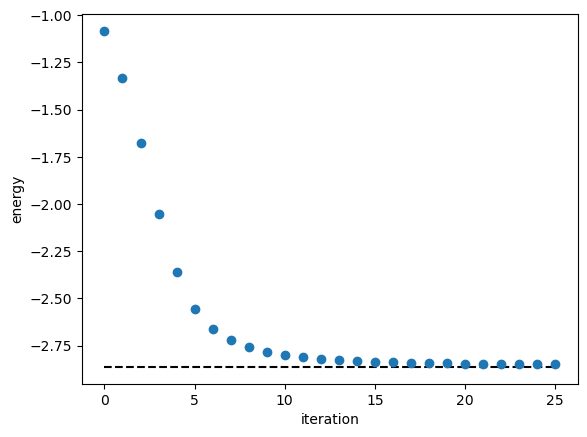

In [11]:
print(f"angles: {theta}")
# plot the results!
plt.plot([0,iterations],[exactEnergy(),exactEnergy()],'--',color='k')
plt.plot(energy_list,'o')
plt.ylabel('energy')
plt.xlabel('iteration')